In [4]:
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
scalesize = 64
#this will get all the png images from all the folder types
path_to_train = "./plant-seedlings-classification/train/*/*.png"

#get all the images present
files = glob(path_to_train)

#now we create 2 lists, one to contain the images
#other to contain the images
train_images_ls = []
train_label_ls = []
num=1
max_size = len(files)

#loop over the file names to read and resize images
#collect the label names as well
for img in files:
  print(str(num)+"/"+str(max_size),end="\r")
  train_images_ls.append(cv2.resize(cv2.imread(img),(scalesize,scalesize)))
  train_label_ls.append(img.split('\\')[-2])
  num +=1
#converting training image list to a numpy array
train_images_ls = np.asarray(train_images_ls)

#converting the labels to pandas 
train_label_ls = pd.DataFrame(train_label_ls)

In [5]:
#summary of the training labels
train_label_ls.value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

### Image Preprocessing

In [6]:
#defining helper functions

def resnet_preprocess(image):
    return preprocess_input(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


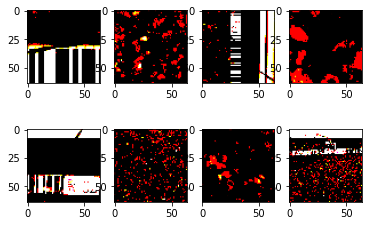

In [7]:
#now creating a new list with the corrected image
segmented_image_ls = []

for i in range(0,len(train_images_ls)):
    segmented_image_ls.append(preprocess_input(train_images_ls[i]))

segmented_image_ls = np.asarray(segmented_image_ls)
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(segmented_image_ls[i])

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


<AxesSubplot:>

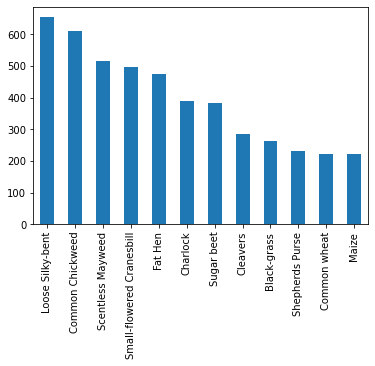

In [8]:
# Encode labels and create classes
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_label_ls[0])
print("Classes: " + str(label_encoder.classes_))
encodeTrainLabels = label_encoder.transform(train_label_ls[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot of label types numbers
train_label_ls[0].value_counts().plot(kind='bar')

In [9]:
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    ) 

### Model Building

In [14]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(64,64,3),
                   pooling='avg',classes=12,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(12, activation='softmax'))

In [15]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

n_split=5
accuracy_ls = []
for train_index,test_index in KFold(n_split,shuffle=True,random_state=7).split(segmented_image_ls):
        x_train,x_test=segmented_image_ls[train_index],segmented_image_ls[test_index]
        y_train,y_test=clearTrainLabel[train_index],clearTrainLabel[test_index]
        datagen.fit(x_train)
        model = resnet_model
        model_checkpoint = ModelCheckpoint('plantspecies_CNN_model.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), 
                    epochs=10, validation_data=(x_test, y_test),   
                    callbacks = [early_stopping, model_checkpoint])
        
        #score and accuracy of the model
        score, acc = model.evaluate(x_test,y_test)
        accuracy_ls.append(acc)
        print(accuracy_ls)
        print('Validation score:', score,'   Validation accuracy:', acc)
        tf.keras.backend.clear_session()
print()
print()
print()
print("Cross Validation Accuracy: ",sum(accuracy_ls)/5)

<ipython-input-15-bf53437d12f2>:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),


Epoch 1/10
119/119 [==============================] - ETA: 0s - loss: 1.8510 - accuracy: 0.4358
Epoch 1: val_accuracy improved from -inf to 0.56316, saving model to plantspecies_CNN_model.h5
119/119 [==============================] - 28s 212ms/step - loss: 1.8510 - accuracy: 0.4358 - val_loss: 1.3074 - val_accuracy: 0.5632
Epoch 2/10
119/119 [==============================] - ETA: 0s - loss: 1.2728 - accuracy: 0.5674
Epoch 2: val_accuracy improved from 0.56316 to 0.63474, saving model to plantspecies_CNN_model.h5
119/119 [==============================] - 27s 224ms/step - loss: 1.2728 - accuracy: 0.5674 - val_loss: 1.1100 - val_accuracy: 0.6347
Epoch 3/10
119/119 [==============================] - ETA: 0s - loss: 1.1419 - accuracy: 0.5968
Epoch 3: val_accuracy improved from 0.63474 to 0.65368, saving model to plantspecies_CNN_model.h5
119/119 [==============================] - 27s 227ms/step - loss: 1.1419 - accuracy: 0.5968 - val_loss: 1.0610 - val_accuracy: 0.6537
Epoch 4/10
119/119 

Epoch 7/10
119/119 [==============================] - ETA: 0s - loss: 0.7607 - accuracy: 0.7287
Epoch 7: val_accuracy did not improve from 0.74526
119/119 [==============================] - 30s 252ms/step - loss: 0.7607 - accuracy: 0.7287 - val_loss: 0.7470 - val_accuracy: 0.7379
Epoch 8/10
119/119 [==============================] - ETA: 0s - loss: 0.7463 - accuracy: 0.7263
Epoch 8: val_accuracy did not improve from 0.74526
119/119 [==============================] - 29s 240ms/step - loss: 0.7463 - accuracy: 0.7263 - val_loss: 0.8109 - val_accuracy: 0.7274
Epoch 9/10
119/119 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.7300
Epoch 9: val_accuracy did not improve from 0.74526
119/119 [==============================] - 35s 292ms/step - loss: 0.7310 - accuracy: 0.7300 - val_loss: 0.7604 - val_accuracy: 0.7347
Epoch 10/10
119/119 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.7318
Epoch 10: val_accuracy improved from 0.74526 to 0.75053, sav

### Final Model Selection and evaluation

In [16]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(segmented_image_ls, clearTrainLabel, 
                                                test_size=0.1, random_state=7, 
                                                stratify = clearTrainLabel)
datagen.fit(trainX)

In [19]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(64,64,3),
                   pooling='avg',classes=12,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(12, activation='softmax'))

resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
final_model = resnet_model
model_checkpoint = ModelCheckpoint('final_plantspecies_CNN_model.h5', #where to save the model
                                            save_best_only=True, 
                                            monitor='val_accuracy', 
                                            mode='max', 
                                            verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = final_model.fit_generator(datagen.flow(trainX, trainY, batch_size=100), 
            epochs=20, validation_data=(testX, testY),   
            callbacks = [early_stopping, model_checkpoint])

<ipython-input-20-7598a63a6e32>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(datagen.flow(trainX, trainY, batch_size=100),


Epoch 1/20
43/43 [==============================] - ETA: 0s - loss: 2.1905 - accuracy: 0.4196
Epoch 1: val_accuracy improved from -inf to 0.56421, saving model to final_plantspecies_CNN_model.h5
43/43 [==============================] - 32s 672ms/step - loss: 2.1905 - accuracy: 0.4196 - val_loss: 1.2923 - val_accuracy: 0.5642
Epoch 2/20
43/43 [==============================] - ETA: 0s - loss: 1.2688 - accuracy: 0.5689
Epoch 2: val_accuracy improved from 0.56421 to 0.59579, saving model to final_plantspecies_CNN_model.h5
43/43 [==============================] - 25s 577ms/step - loss: 1.2688 - accuracy: 0.5689 - val_loss: 1.1370 - val_accuracy: 0.5958
Epoch 3/20
43/43 [==============================] - ETA: 0s - loss: 1.1674 - accuracy: 0.5930
Epoch 3: val_accuracy did not improve from 0.59579
43/43 [==============================] - 29s 678ms/step - loss: 1.1674 - accuracy: 0.5930 - val_loss: 1.1734 - val_accuracy: 0.5621
Epoch 4/20
43/43 [==============================] - ETA: 0s - loss

15/15 [==============================] - 4s 174ms/step


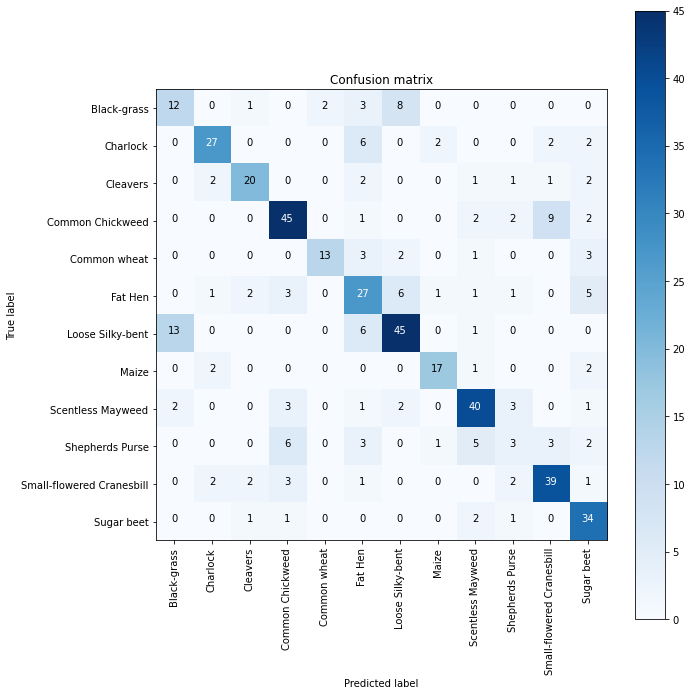

In [21]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = final_model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = label_encoder.classes_)

### Generating Test Output

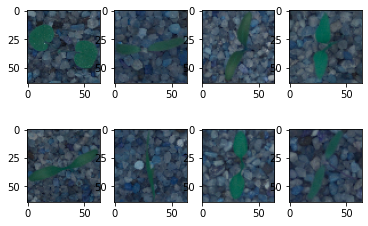

In [22]:
path = './plant-seedlings-classification/test/*.png'
files = glob(path)

testImg = []
testId = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print("Obtain images: " + str(j) + "/" + str(num), end='\r')
    testId.append(img.split('\\')[-1])  # Images id's
    testImg.append(cv2.resize(cv2.imread(img), (scalesize, scalesize)))
    j += 1

testImg = np.asarray(testImg)  # Train images set

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(testImg[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


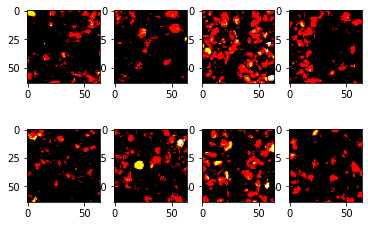

In [23]:
#now creating a new list with the corrected image
segmented_test_image_ls = []

for i in range(0,len(testImg)):
    segmented_test_image_ls.append(resnet_preprocess(testImg[i]))

segmented_test_image_ls = np.asarray(segmented_test_image_ls)
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(segmented_test_image_ls[i])

In [24]:
pred = final_model.predict(segmented_test_image_ls)

25/25 [==============================] - 5s 202ms/step


In [25]:
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = label_encoder.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("submission.csv", index=False)